# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("customer_booking.csv")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df.to_csv("customer_booking_mapped_weeks.csv", index=False)

In [9]:
# Convert flight_day into a new feature indicating weekend/weekday
df['is_weekend'] = df['flight_day'].apply(lambda x: 1 if x in [6, 7] else 0)


In [10]:
# calculation of average metrics on the basis of sales channel
aggregated_data = df.groupby('sales_channel').agg({
    'purchase_lead': 'mean',
    'length_of_stay': 'mean',
    'flight_duration': 'mean',
    'booking_complete': 'mean'
}).reset_index()
print(aggregated_data)

  sales_channel  purchase_lead  length_of_stay  flight_duration  \
0      Internet      85.371682       23.772205         7.298133   
1        Mobile      81.533998       17.296191         7.115043   

   booking_complete  
0          0.154770  
1          0.108402  


In [11]:
# Normalize numerical features
# numerical_cols = ['purchase_lead', 'length_of_stay', 'flight_duration']
# scaler = MinMaxScaler()
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [12]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,is_weekend
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,0


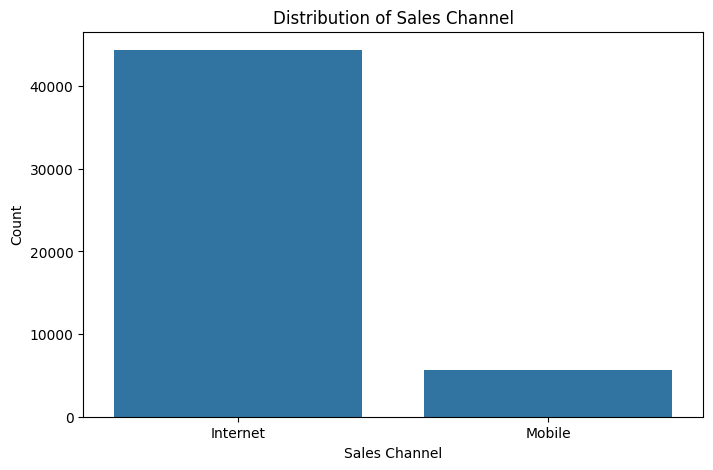

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sales_channel')
plt.title('Distribution of Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.show()

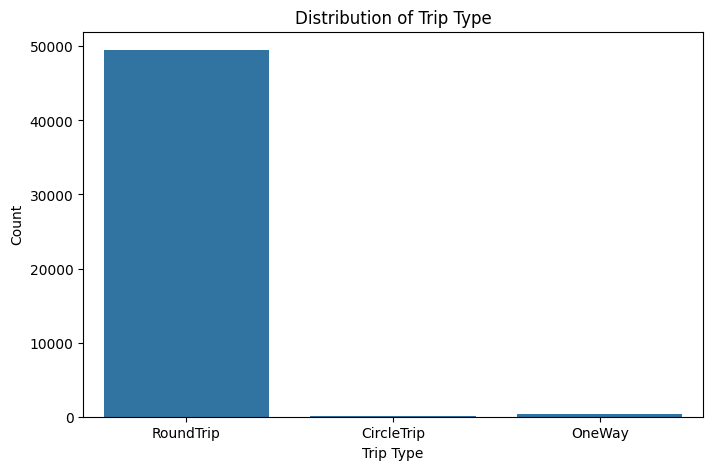

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='trip_type')
plt.title('Distribution of Trip Type')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.show()

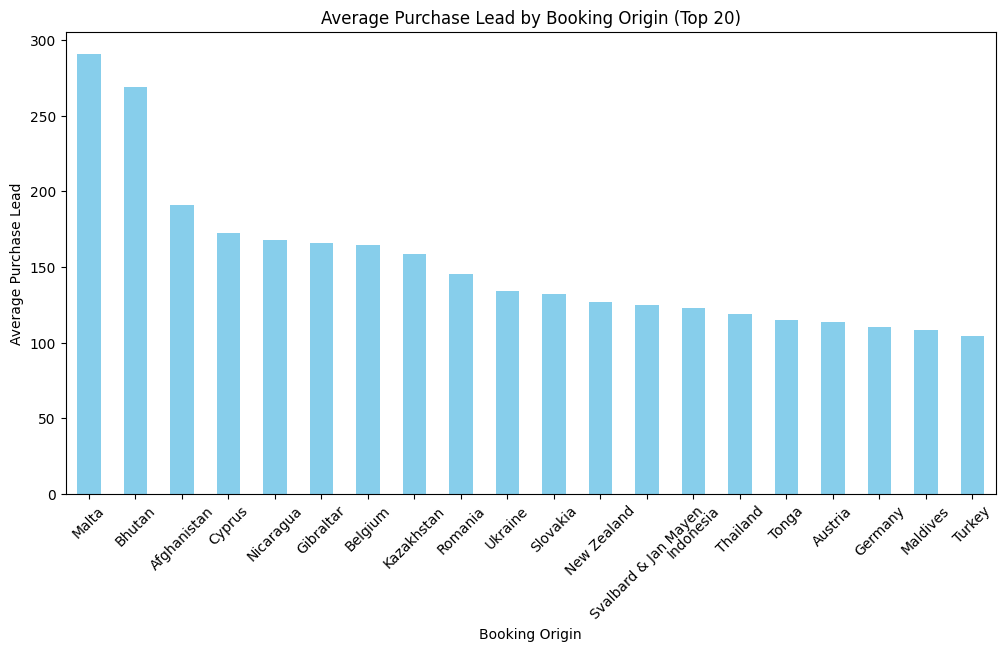

In [15]:
plt.figure(figsize=(12, 6))
avg_purchase_lead = df.groupby('booking_origin')['purchase_lead'].mean().sort_values(ascending=False)
avg_purchase_lead.head(20).plot(kind='bar', color='skyblue')
plt.title('Average Purchase Lead by Booking Origin (Top 20)')
plt.xlabel('Booking Origin')
plt.ylabel('Average Purchase Lead')
plt.xticks(rotation=45)
plt.show()

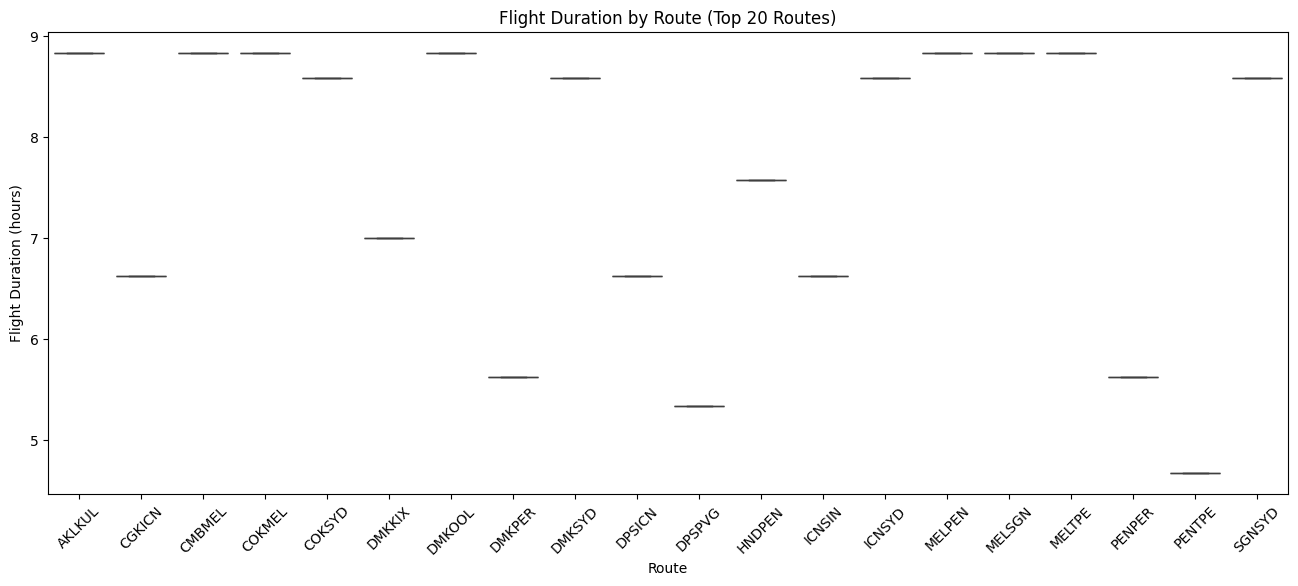

In [16]:
# Due to high cardinality of 'route', show top 20 routes by count
top_routes = df['route'].value_counts().head(20).index
filtered_data = df[df['route'].isin(top_routes)]

plt.figure(figsize=(16, 6))
sns.boxplot(data=filtered_data, x='route', y='flight_duration')
plt.title('Flight Duration by Route (Top 20 Routes)')
plt.xlabel('Route')
plt.ylabel('Flight Duration (hours)')
plt.xticks(rotation=45)
plt.show()

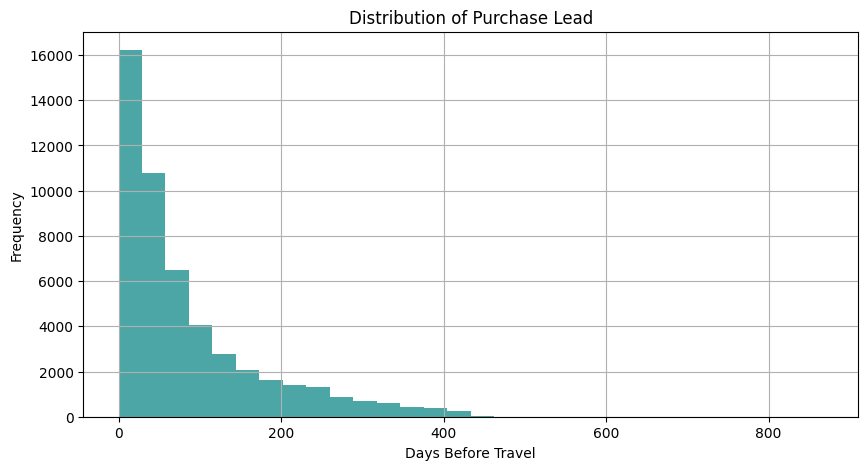

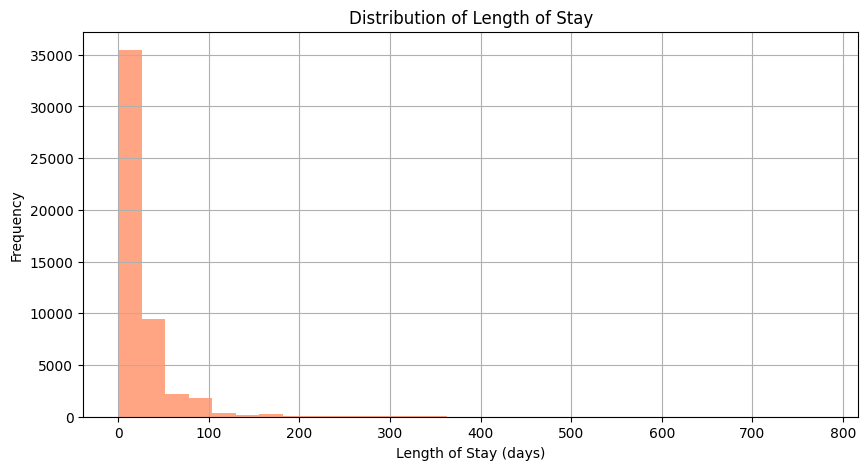

In [17]:
plt.figure(figsize=(10, 5))
df['purchase_lead'].hist(bins=30, color='teal', alpha=0.7)
plt.title('Distribution of Purchase Lead')
plt.xlabel('Days Before Travel')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
df['length_of_stay'].hist(bins=30, color='coral', alpha=0.7)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

In [18]:
categorical_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin']
encoded_data = df.copy()
for col in categorical_cols:
    encoder = LabelEncoder()
    encoded_data[col] = encoder.fit_transform(encoded_data[col])

numerical_cols = ['purchase_lead', 'length_of_stay', 'flight_duration']
scaler = MinMaxScaler()
encoded_data[numerical_cols] = scaler.fit_transform(encoded_data[numerical_cols])

# Define features (X) and target (y)
X = encoded_data.drop(columns=['booking_complete'])  # Predictor variables
y = encoded_data['booking_complete']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
'''smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
print("Best Parameters:", grid_search.best_params_) '''

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8552

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.56      0.10      0.17      1480

    accuracy                           0.86     10000
   macro avg       0.71      0.54      0.54     10000
weighted avg       0.82      0.86      0.81     10000



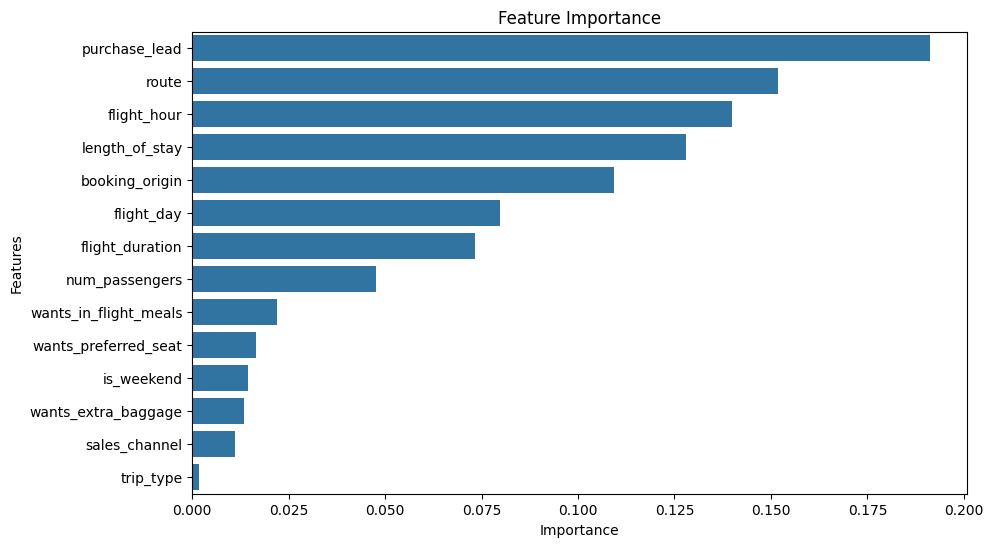

In [20]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [21]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Perform cross-validation
cv_results = cross_validate(rf_model, X, y, cv=5, scoring=scoring, return_train_score=True)

# Display average performance metrics
print("Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.3f}")
print(f"Precision: {cv_results['test_precision'].mean():.3f}")
print(f"Recall: {cv_results['test_recall'].mean():.3f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.3f}")

Cross-Validation Results:
Accuracy: 0.511
Precision: 0.230
Recall: 0.166
F1 Score: 0.079


In [22]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate with the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Improved Accuracy:", accuracy_score(y_test, y_pred_best))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Improved Accuracy: 0.8558
